https://keras.io/api/losses/ 

# Denoising the spectrum by  

**We try to see if the autoencoder can map spectra onto another spectrum, which is the average of all QC's**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers
import pandas as pd

Loading the data

In [2]:
#From Maik
path_data = '//z-sv-dfsroot/dfsroot/project/agzigman/MIRA Anaylzer - Eval/L4L_all_samples/Serum/'   # path for json files

path = '//z-sv-pool12c/pool12c_home/c/Corinna.Wegner/Documents/pilot study/pilot study/' # location of cohort metafiles

meta_full = '//z-sv-pool12c/pool12c_home/c/Corinna.Wegner/Documents/L4L_metatags_Serum_20220719.csv'  

metafile_full = pd.read_csv(meta_full, delimiter=';')
metafile_full = metafile_full[['File Name']]
metafile_full = metafile_full.rename(columns={'File Name':'filename'})
metafile_full = metafile_full.drop_duplicates(subset='filename', keep="first")

metafile_0 = pd.read_excel(path + 'LuCa_VS_NSR_all_samples_excluded1_drifted_train_0_matched.xlsx')
metafile_0 = metafile_0[['filename','cancer_status']]

metafile_1 = pd.read_excel(path + 'LuCa_VS_NSR_all_samples_excluded1_drifted_train_1_matched.xlsx')
metafile_1 = metafile_1[['filename','cancer_status']]

metafile_2 = pd.read_excel(path + 'LuCa_VS_NSR_all_samples_excluded1_drifted_train_2_matched.xlsx')
metafile_2 = metafile_2[['filename','cancer_status']]

# Inner merge of complete metafile with individuals to get intersection between them (From Maik)

merged_0 = pd.merge(left=metafile_full, right=metafile_0, how='inner')
merged_1 = pd.merge(left=metafile_full, right=metafile_1, how='inner')
merged_2 = pd.merge(left=metafile_full, right=metafile_2, how='inner')

In [3]:
import numpy as np
import os.path 
import json as js 

metafiles_labels = {0: merged_0,
                    1: merged_1,
                    2: merged_2}

spectra_path = "//z-sv-dfsroot/dfsroot/project/agzigman/MIRA Anaylzer - Eval/L4L_all_samples/Serum"

absorbances = []
labels = []

for label, metafile in metafiles_labels.items():
    for i in range(1, len(metafile)):
        #k=0
        ID = metafile["filename"][i] + ".json"
        spectrum_path_id ="%s/%s"%(spectra_path,ID) 
        if os.path.isfile(spectrum_path_id):
            f = open(spectrum_path_id, "r")
            spect = js.loads(f.read(), strict=False)
            ab_data = spect["AB Data"]
            ab_data = list(reversed(ab_data))
            absorbances.append(ab_data)
            labels.append(label)
        else:
            print('no file found')
        
absorbances = np.array(absorbances)

Preprocessing

In [4]:
x_data =  absorbances #data with the spectra

#extracting silent region from x
range_silent = [1800, 2300]

vec = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\sample.txt", sep='\t')
vec = vec.X
vec_ = vec.to_list()

for i in range(len(vec_)):
    if vec_[i]<range_silent[0] and vec[i+1]>=range_silent[0]:
        min_index = i+1
    if vec_[i]<=range_silent[1] and vec[i+1]>range_silent[1]:
        max_index = i
        
silent_region = [spect[min_index:max_index] for spect in absorbances]
silent_region = np.array(silent_region)

#averaging qc spectra
qcs = np.loadtxt("qcs_real.txt", delimiter=",")
avg_qc = np.average(qcs, axis=0)

In [5]:
from scipy.signal import savgol_filter
#Savgol filter
#x_data = savgol_filter(x_data, window_length = 9, polyorder=2, deriv=1)

#splitting data into train and test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(x_data, test_size=0.2, random_state=42, shuffle=True, stratify=None)

#normalizing the data
from sklearn.preprocessing import normalize
train = normalize(train, norm='l2')
test = normalize(test, norm='l2')

#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler_test = StandardScaler()
standardscaler_train = StandardScaler()
test_scaled = standardscaler_test.fit_transform(test)
train = standardscaler_train.fit_transform(train)

#reshaping the data
train = train.reshape(train.shape[0],train.shape[1],1)
test_scaled = test_scaled.reshape(test_scaled.shape[0],test_scaled.shape[1],1)

Defining and training the model

In [6]:
#https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression really nice documentation
#https://keras.io/examples/timeseries/timeseries_anomaly_detection/
activation = "elu"
filter_size = 53
strides = 2
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

model = keras.models.Sequential(name="autoencoder_conv1d")
model.add(layers.InputLayer(input_shape=(train.shape[1],train.shape[2])))
model.add(layers.Conv1D(num_filters4, filter_size, strides))
model.add(layers.Conv1D(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters1, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters4, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(1,filter_size, strides=strides, activation=activation))  

print(model.summary())

Model: "autoencoder_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 525, 128)          6912      
                                                                 
 conv1d_1 (Conv1D)           (None, 237, 64)           434240    
                                                                 
 conv1d_2 (Conv1D)           (None, 93, 32)            108576    
                                                                 
 conv1d_3 (Conv1D)           (None, 21, 16)            27152     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 93, 32)           27168     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 237, 64)          108608    
 ranspose)                                      

In [7]:
avg_qc_matrix = []
for i in range(train.shape[0]):
    avg_qc_matrix.append(avg_qc)
avg_qc_matrix = np.array(avg_qc_matrix)

In [8]:
avg_qc_matrix = avg_qc_matrix.reshape(avg_qc_matrix.shape[0], avg_qc_matrix.shape[1],1)

In [9]:
avg_qc_matrix.shape

(1448, 1101, 1)

In [10]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

results = model.fit(train, avg_qc_matrix,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[earlystopping, rl_on_plateau])

Epoch 1/50
11/11 [==============================] - 12s 977ms/step - loss: 0.0094 - val_loss: 0.0051 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 10s 907ms/step - loss: 0.0019 - val_loss: 0.0015 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 10s 902ms/step - loss: 7.2351e-04 - val_loss: 4.0050e-04 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 10s 885ms/step - loss: 1.9173e-04 - val_loss: 8.8109e-05 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 10s 939ms/step - loss: 6.6505e-05 - val_loss: 4.1556e-05 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - ETA: 0s - loss: 3.0102e-05
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
11/11 [==============================] - 10s 947ms/step - loss: 3.0102e-05 - val_loss: 2.5203e-05 - lr: 0.0010
Epoch 7/50
11/11 [==============================] - 10s 883ms/step - loss: 1.8873e-05 - val_loss: 1.6824e-05 - lr: 6.7000e-04
Epoch 8/50
11/

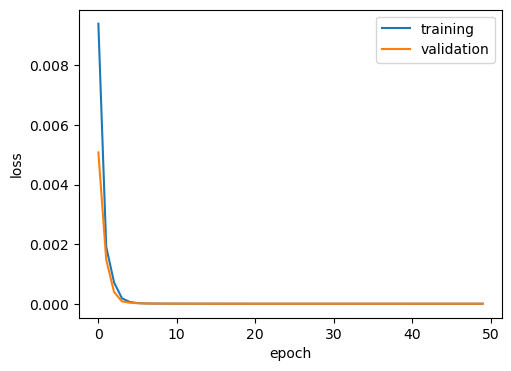

In [11]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [12]:
preds = model.predict(test_scaled, verbose=1)
preds_rescaled = standardscaler_test.inverse_transform(tf.squeeze(preds))

12/12 [==============================] - 1s 66ms/step


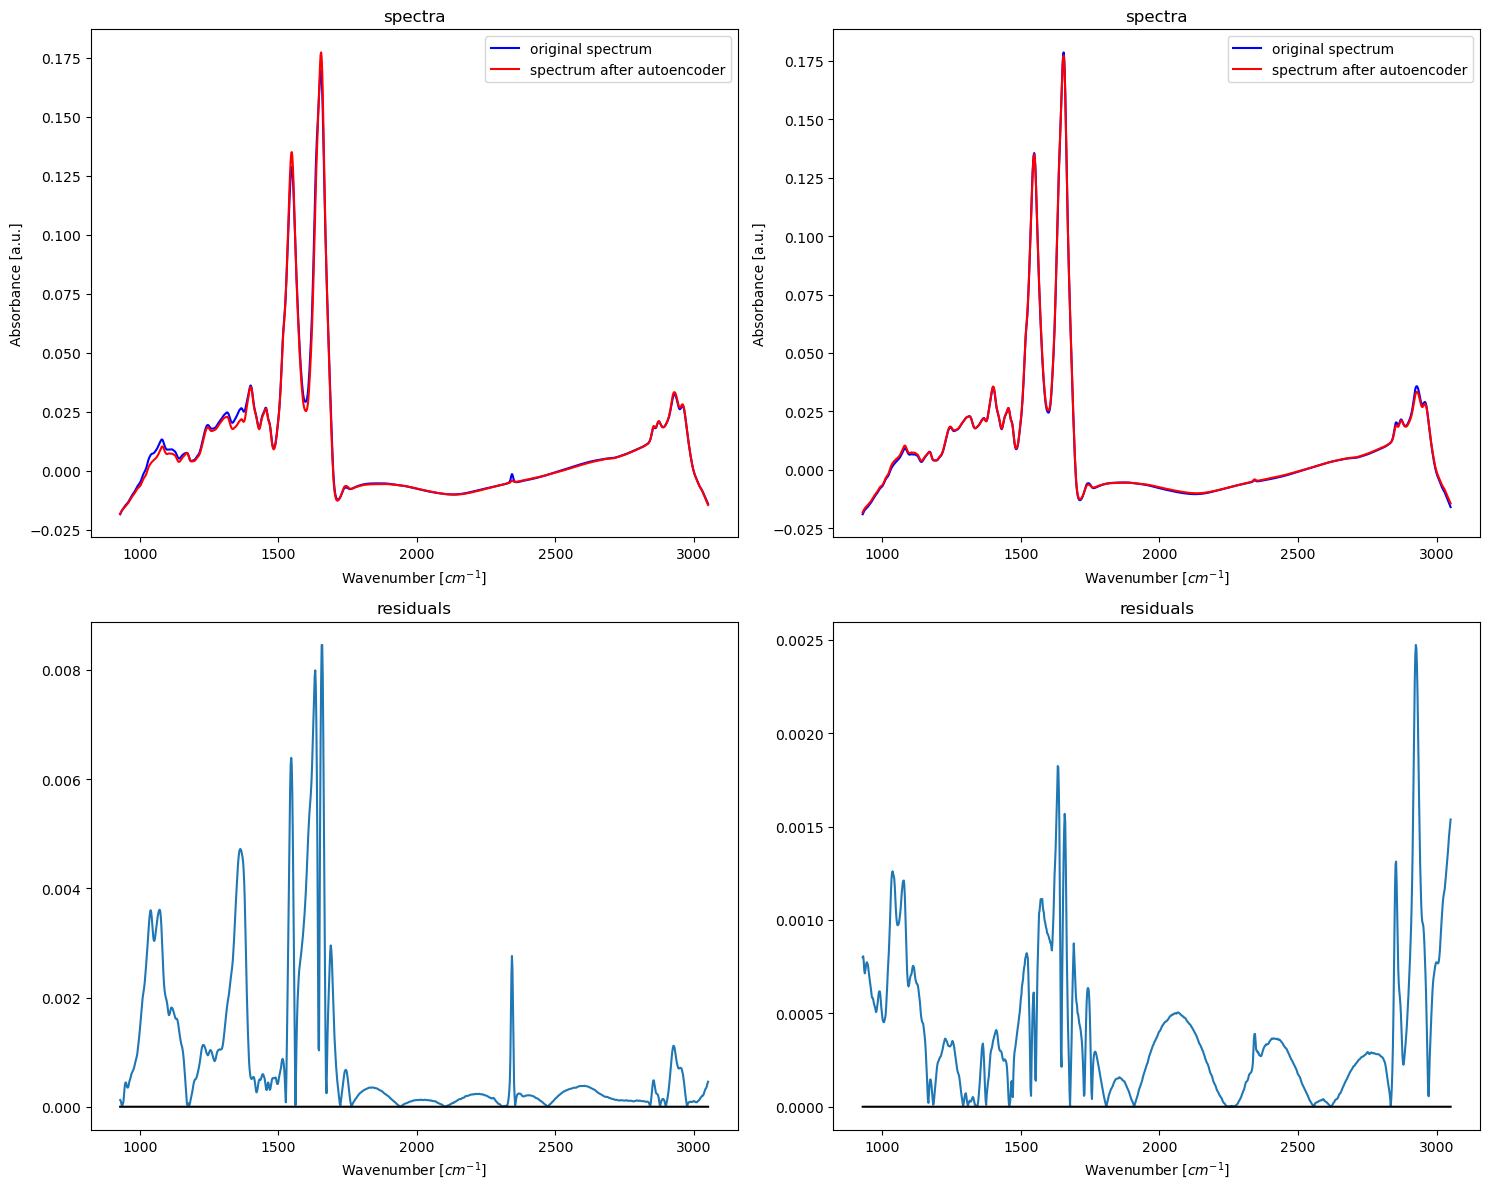

In [13]:
plots = 2
n_test = test.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

for i in range(plots):
    ax1[i].plot(xaxis, test[idx[i]],'b', markersize= 0.5, label="original spectrum")
    ax1[i].plot(xaxis, preds_rescaled[idx[i]], 'r', markersize=0.5, label="spectrum after autoencoder")
    
    ax1[i].legend(loc=1)
    ax1[i].set_ylabel('Absorbance [a.u.]')
    ax1[i].set_xlabel('Wavenumber [$cm^{-1}$]')
    ax2[i].set_xlabel('Wavenumber [$cm^{-1}$]')
    ax1[i].set_title("spectra")

    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")
    ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
    ax2[i].set_title("residuals")
    
plt.tight_layout()
plt.show()

One does not see the difference in the silent regions, because it is too small. To investigate the differences between the spectra we therefore perform a t-SNE of the test set before and after the autoencoder (only the silent region).

### Evaluating the silent regions

In [14]:
test_sc = tf.squeeze(test_scaled)
test_sc = [spect[min_index:max_index] for spect in test_sc]
test_sc = np.array(test_sc)

preds_sc = tf.squeeze(preds)
preds_sc = [spect[min_index:max_index] for spect in preds_sc]
preds_sc = np.array(preds_sc)

In [15]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
tsne_results_before = tsne.fit_transform(test_sc)
tsne_results_after = tsne.fit_transform(preds_sc)

x_tsne = tsne_results_before[:,0]
y_tsne = tsne_results_before[:,1]

x_tsne_a = tsne_results_after[:,0]
y_tsne_a = tsne_results_after[:,1]

tsne_df_b = pd.DataFrame(dict(x=x_tsne, y=y_tsne, label="original spectra"))
tsne_df_a = pd.DataFrame(dict(x=x_tsne_a, y=y_tsne_a, label="spectra after autoencoder"))
tsne_df = pd.concat([tsne_df_b, tsne_df_a])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 363 samples in 0.000s...
[t-SNE] Computed neighbors for 363 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 363 / 363
[t-SNE] Mean sigma: 3.313289
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.400181
[t-SNE] KL divergence after 500 iterations: 0.228195
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 363 samples in 0.000s...
[t-SNE] Computed neighbors for 363 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 363 / 363
[t-SNE] Mean sigma: 0.015789


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.180130
[t-SNE] KL divergence after 500 iterations: 0.706331


Text(0.5, 1.0, 'T-SNE of the silent region')

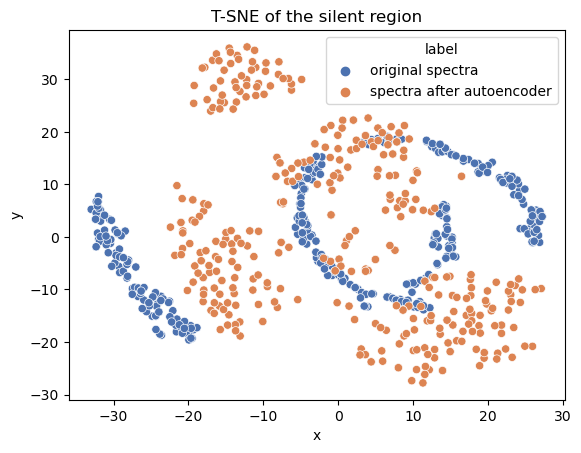

In [16]:
import seaborn as sns
sns.scatterplot(data=tsne_df, x="x", y="y", hue="label", palette="deep")
plt.title("T-SNE of the silent region")

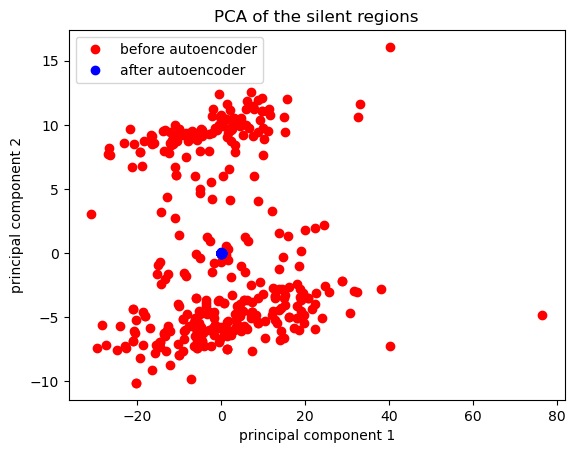

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(test_sc)
principalComponents_a = pca.fit_transform(preds_sc)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf_a = pd.DataFrame(data = principalComponents_a, columns = ['principal component 1', 'principal component 2'])

xaxis = list(principalDf["principal component 1"])
yaxis = list(principalDf["principal component 2"])
xaxis_a = list(principalDf_a["principal component 1"])
yaxis_a = list(principalDf_a["principal component 2"])

plt.plot(xaxis, yaxis,'ro', label='before autoencoder')#, markersize= 0.5)
plt.plot(xaxis_a, yaxis_a, 'bo', label='after autoencoder')#, markersize= 0.5)

plt.title("PCA of the silent regions")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.legend()

### Evaluating the whole spectra

In [18]:
#Removing the additional dimension needed for the CNN
test_sc = tf.squeeze(test_scaled)
preds_sc = tf.squeeze(preds)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 363 samples in 0.000s...
[t-SNE] Computed neighbors for 363 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 363 / 363
[t-SNE] Mean sigma: 11.060219
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.391174
[t-SNE] KL divergence after 500 iterations: 0.667189
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 363 samples in 0.000s...
[t-SNE] Computed neighbors for 363 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 363 / 363
[t-SNE] Mean sigma: 0.025707


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.950348
[t-SNE] KL divergence after 500 iterations: 0.637901


Text(0.5, 1.0, 'T-SNE of the whole spectra')

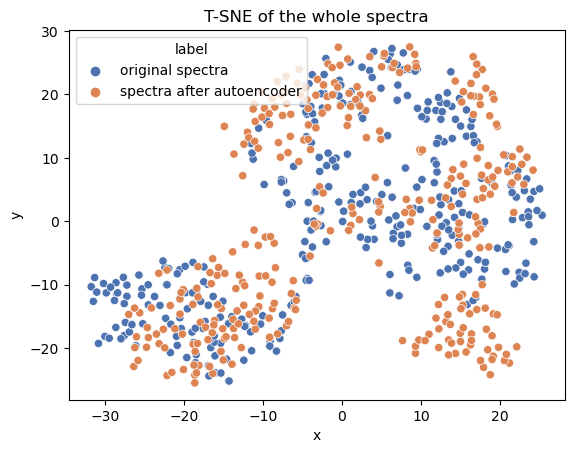

In [19]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
tsne_results_before = tsne.fit_transform(test_sc)
tsne_results_after = tsne.fit_transform(preds_sc)

x_tsne = tsne_results_before[:,0]
y_tsne = tsne_results_before[:,1]

x_tsne_a = tsne_results_after[:,0]
y_tsne_a = tsne_results_after[:,1]

tsne_df_b = pd.DataFrame(dict(x=x_tsne, y=y_tsne, label="original spectra"))
tsne_df_a = pd.DataFrame(dict(x=x_tsne_a, y=y_tsne_a, label="spectra after autoencoder"))
tsne_df = pd.concat([tsne_df_b, tsne_df_a])

import seaborn as sns
sns.scatterplot(data=tsne_df, x="x", y="y", hue="label", palette="deep")
plt.title("T-SNE of the whole spectra")

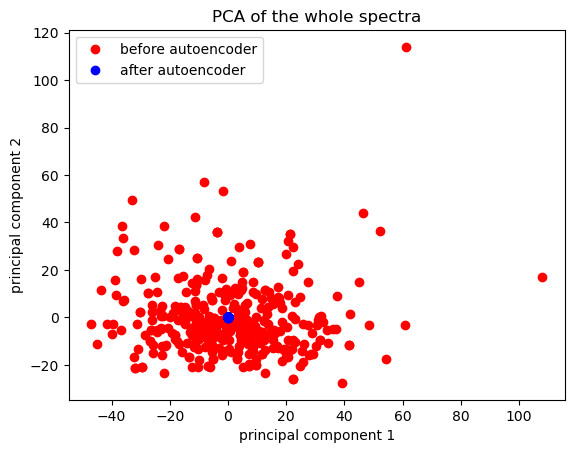

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(test_sc)
principalComponents_a = pca.fit_transform(preds_sc)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf_a = pd.DataFrame(data = principalComponents_a, columns = ['principal component 1', 'principal component 2'])

xaxis = list(principalDf["principal component 1"])
yaxis = list(principalDf["principal component 2"])
xaxis_a = list(principalDf_a["principal component 1"])
yaxis_a = list(principalDf_a["principal component 2"])

plt.plot(xaxis, yaxis, 'ro', label='before autoencoder')#, markersize= 0.5)
plt.plot(xaxis_a, yaxis_a, 'bo', label='after autoencoder')#, markersize= 0.5)

plt.title("PCA of the whole spectra")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.legend()

**Result: the autoencoder is well able to map the whole spectra as well as only the silent regions onto one single spectrum.**